In [871]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [872]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [835]:
def gaussian(f, f_0, a, sigma, c, b):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def linear(x, a, b):
    return a*x + b

def get_gaussian_fit(detunings, voltages):    
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.fit()
    
    return fitter

def get_linear_fit(amplitudes, heights):
    fitter = Fitter(linear)
    fitter.set_absolute_sigma(False)
    fitter.set_data(amplitudes, heights)
    fitter.fit()

    return fitter


In [832]:
def data_groups(data, headers):
    chasm_repeats = headers["params"]["detect"]["chasm_repeats"]
    antihole_repeats = headers["params"]["detect"]["antihole_repeats"]
    if "rf_repeats" in headers["params"]["detect"]:
        rf_repeats = headers["params"]["detect"]["rf_repeats"]
    else:
        rf_repeats = 0
    total_detect_repeats = chasm_repeats + antihole_repeats + rf_repeats
    experiment_repeats = headers["params"]["repeats"]

    chasm_avg = []
    antihole_avg = []
    rf_avg = []
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_detect_repeats
        if remainder < chasm_repeats:
            chasm_avg.append(data["transmissions_avg"][kk])
        elif remainder < chasm_repeats + antihole_repeats:
            antihole_avg.append(data["transmissions_avg"][kk])
        else:
            rf_avg.append(data["transmissions_avg"][kk])
    chasm_avg = np.array(chasm_avg)
    antihole_avg = np.array(antihole_avg)
    rf_avg = np.array(rf_avg)
    chasm_avg = np.average(chasm_avg, axis=0)
    antihole_avg = np.average(antihole_avg, axis=0)
    rf_avg = np.average(rf_avg, axis=0)

    if "monitors_avg" in data:
        monitor_chasm_avg = []
        monitor_antihole_avg = []
        monitor_rf_avg = []
        for kk in range(len(data["monitors_avg"])):
            remainder = kk % total_detect_repeats
            if remainder < chasm_repeats:
                monitor_chasm_avg.append(data["monitors_avg"][kk])
            elif remainder < chasm_repeats + antihole_repeats:
                monitor_antihole_avg.append(data["monitors_avg"][kk])
            else:
                monitor_rf_avg.append(data["monitors_avg"][kk])
        monitor_chasm_avg = np.array(monitor_chasm_avg)
        monitor_antihole_avg = np.array(monitor_antihole_avg)
        monitor_rf_avg = np.array(monitor_rf_avg)
        monitor_chasm_avg = np.average(monitor_chasm_avg, axis=0)
        monitor_antihole_avg = np.average(monitor_antihole_avg, axis=0)
        monitor_rf_avg = np.average(monitor_rf_avg, axis=0)
        return ((chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg))
    
    return (chasm_avg, antihole_avg, rf_avg)

/tmp/ipykernel_29082/4204129173.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return a * quad(integrand, -span, span)[0] + c
/tmp/ipykernel_29082/4204129173.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return a * quad(integrand, -span, span)[0] + c


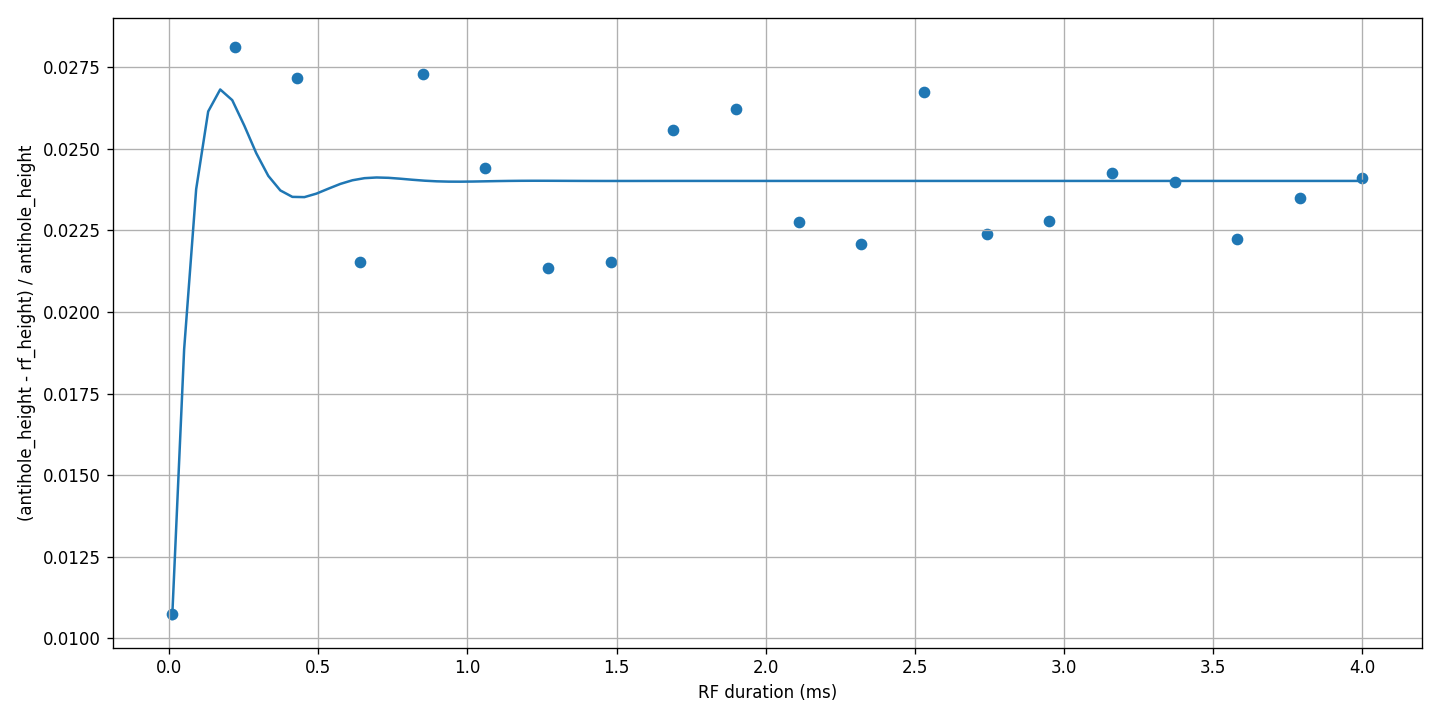

20


In [898]:
rf_offsets = []
antihole_heights = []
antihole_height_errs = []
rf_heights = []
rf_height_errs = []
durations = []
# for kk in range(3599, 3719):
# for kk in range(3719, 3769):
# for kk in range(3769, 3779):
# for kk in range(3800, 3870):
# for kk in range(3890, 3910):
# for kk in range(3910, 3930):
for kk in range(3930, 3950):
    data, headers = get_experiment_data(kk)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    # rf_offset = headers["params"]["rf"]["offset"].to("kHz").magnitude    
    rf_offset = headers["params"]["rf"]["duration"].magnitude
    # durations.append(headers["params"]["rf"]["duration"].to("ms").magnitude)
    rf_offsets.append(rf_offset)
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
    antihole_fit = get_gaussian_fit(detunings_MHz, antihole_avg/chasm_avg)
    rf_fit = get_gaussian_fit(detunings_MHz, rf_avg/chasm_avg)
    antihole_heights.append(antihole_fit.results["a"])
    antihole_height_errs.append(antihole_fit.errors["a"])
    rf_heights.append(rf_fit.results["a"])
    rf_height_errs.append(rf_fit.errors["a"])

rf_offsets = np.array(rf_offsets)
no_repeat_durations = list(dict.fromkeys(durations))
durations = np.array(durations)
antihole_heights = np.array(antihole_heights)
antihole_height_errs = np.array(antihole_height_errs)
rf_heights = np.array(rf_heights)
rf_height_errs = np.array(rf_height_errs)

fig, ax = plt.subplots(figsize=(12, 6), dpi = 120)
# ax.set_xlabel("RF offset from 119.2 MHz (kHz)")
ax.set_xlabel("RF duration (ms)")
ax.set_ylabel("(antihole_height - rf_height) / antihole_height")
ratios = rf_heights / antihole_heights
ratio_errs = ratios * np.sqrt(
    (rf_height_errs / rf_heights) ** 2
    + (antihole_height_errs / antihole_heights) ** 2
)
colors = np.linspace(0, 1, len(ratios))

# for k in range(len(no_repeat_durations)):
#     mask = durations == no_repeat_durations[k]
#     amplitudes = rf_offsets[mask]
#     heights = 1 - ratios[mask]
#     fit = get_linear_fit(amplitudes, heights)
#     xaxis = np.linspace(min(amplitudes), max(amplitudes), 100)
#     # ax.plot(xaxis, fit.fitted_value(xaxis), color=f"C{k}")
#     # ax.errorbar(rf_offsets[mask], 1 - ratios[mask], ratio_errs[mask], label=f"{no_repeat_durations[k]} ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
#     ax.scatter(rf_offsets[mask], 1 - ratios[mask])

ax.scatter(rf_offsets, 1 - ratios)
fitter = Fitter(p_excited_with_inhomogenous, array_compatible=False)
fitter.set_p0({"a": 0.5, "c": 0.01, "tau": 0.01, "Omega": 2*np.pi * 2e3})
fitter.set_absolute_sigma(False)
fitter.set_bounds("tau", 0)
fitter.set_data(rf_offsets / 1e3, 1 - ratios)
fitter.fit()
xaxis = np.linspace(min(rf_offsets), max(rf_offsets), 100)
ax.plot(xaxis, fitter.fitted_value(xaxis / 1e3))

# colorss = ["C0", "C1", "C2"]
# labels = ["0.05 ms duration"
# for k in range(3):
#     amplitudes = rf_offsets[k*10:(k+1)*10]
#     heights = 1 - ratios[k*10:(k+1)*10]
#     fit = get_linear_fit(amplitudes, heights)
#     xaxis = np.linspace(min(amplitudes), max(amplitudes), 100)
#     ax.plot(xaxis, fit.fitted_value(xaxis), color=colorss[k])
#     ax.errorbar(rf_offsets[k*10:(k+1)*10], 1 - ratios[k*10:(k+1)*10], ratio_errs[k*10:(k+1)*10], label="0.05 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)

# ax.errorbar(rf_offsets[0:10], 1 - ratios[0:10], ratio_errs[0:10], label="0.05 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
# ax.errorbar(rf_offsets[10:20], 1 - ratios[10:20], ratio_errs[10:20], label="0.1 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
# ax.errorbar(rf_offsets[20:30], 1 - ratios[20:30], ratio_errs[20:30], label="0.03 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
# ax.errorbar(rf_offsets[20:30], 1 - ratios[20:30], ratio_errs[20:30], label="0.03 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)

# ca = ax.scatter(rf_offsets, 1 - ratios, c = colors, cmap = "jet", zorder = 2)
# ax.legend()
# cbar = plt.colorbar(ca)
cbar.ax.text(5, 1, "Latest data", ha='center', va='center')
cbar.ax.text(5, 0, "Oldest data", ha='center', va='center')
plt.tight_layout()
plt.grid()
plt.show()
print(len(ratios))

0.05
0.1
0.03
0.2
0.5
0.201
1


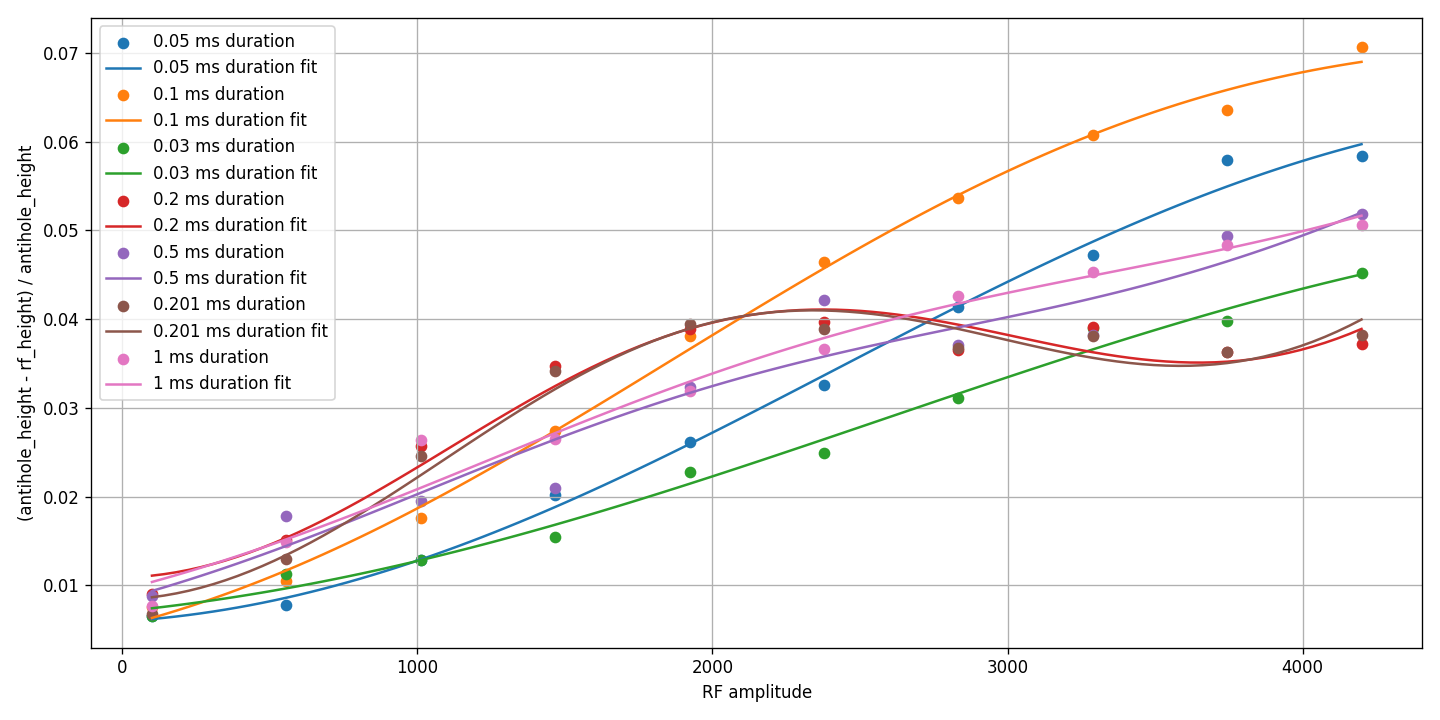

70


In [897]:
rf_offsets = []
antihole_heights = []
antihole_height_errs = []
rf_heights = []
rf_height_errs = []
durations = []
# for kk in range(3599, 3719):
# for kk in range(3719, 3769):
# for kk in range(3769, 3779):
#for kk in range(3800, 3870):
for kk in range(3800, 3870):
    data, headers = get_experiment_data(kk)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    # rf_offset = headers["params"]["rf"]["offset"].to("kHz").magnitude    
    rf_offset = headers["params"]["rf"]["amplitude"]
    durations.append(headers["params"]["rf"]["duration"].to("ms").magnitude)
    rf_offsets.append(rf_offset)
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
    antihole_fit = get_gaussian_fit(detunings_MHz, antihole_avg/chasm_avg)
    rf_fit = get_gaussian_fit(detunings_MHz, rf_avg/chasm_avg)
    antihole_heights.append(antihole_fit.results["a"])
    antihole_height_errs.append(antihole_fit.errors["a"])
    rf_heights.append(rf_fit.results["a"])
    rf_height_errs.append(rf_fit.errors["a"])

rf_offsets = np.array(rf_offsets)
no_repeat_durations = list(dict.fromkeys(durations))
durations = np.array(durations)
antihole_heights = np.array(antihole_heights)
antihole_height_errs = np.array(antihole_height_errs)
rf_heights = np.array(rf_heights)
rf_height_errs = np.array(rf_height_errs)

fig, ax = plt.subplots(figsize=(12, 6), dpi = 120)
# ax.set_xlabel("RF offset from 119.2 MHz (kHz)")
ax.set_xlabel("RF amplitude")
ax.set_ylabel("(antihole_height - rf_height) / antihole_height")
ratios = rf_heights / antihole_heights
ratio_errs = ratios * np.sqrt(
    (rf_height_errs / rf_heights) ** 2
    + (antihole_height_errs / antihole_heights) ** 2
)
colors = np.linspace(0, 1, len(ratios))

for k in range(len(no_repeat_durations)):
    mask = durations == no_repeat_durations[k]
    amplitudes = rf_offsets[mask]
    heights = 1 - ratios[mask]
    fit = get_linear_fit(amplitudes, heights)
    xaxis = np.linspace(min(amplitudes), max(amplitudes), 100)
    # ax.plot(xaxis, fit.fitted_value(xaxis), color=f"C{k}")
    # ax.errorbar(rf_offsets[mask], 1 - ratios[mask], ratio_errs[mask], label=f"{no_repeat_durations[k]} ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
    ax.scatter(rf_offsets[mask], 1 - ratios[mask], label=f"{no_repeat_durations[k]} ms duration")
    fitter = Fitter(partial(p_excited_with_inhomogenous_1, no_repeat_durations[k] / 1e3), array_compatible=False)
    fitter.set_p0({"a": 0.5, "c": 0.01, "tau": 0.01})
    fitter.set_absolute_sigma(False)
    fitter.set_bounds("tau", 0)
    fitter.set_data(rf_offsets[mask], 1 - ratios[mask])
    fitter.fit()
    xaxis = np.linspace(min(rf_offsets[mask]), max(rf_offsets[mask]), 100)
    ax.plot(xaxis, fitter.fitted_value(xaxis), label=f"{no_repeat_durations[k]} ms duration fit")
    print(no_repeat_durations[k])

# colorss = ["C0", "C1", "C2"]
# labels = ["0.05 ms duration"
# for k in range(3):
#     amplitudes = rf_offsets[k*10:(k+1)*10]
#     heights = 1 - ratios[k*10:(k+1)*10]
#     fit = get_linear_fit(amplitudes, heights)
#     xaxis = np.linspace(min(amplitudes), max(amplitudes), 100)
#     ax.plot(xaxis, fit.fitted_value(xaxis), color=colorss[k])
#     ax.errorbar(rf_offsets[k*10:(k+1)*10], 1 - ratios[k*10:(k+1)*10], ratio_errs[k*10:(k+1)*10], label="0.05 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)

# ax.errorbar(rf_offsets[0:10], 1 - ratios[0:10], ratio_errs[0:10], label="0.05 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
# ax.errorbar(rf_offsets[10:20], 1 - ratios[10:20], ratio_errs[10:20], label="0.1 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
# ax.errorbar(rf_offsets[20:30], 1 - ratios[20:30], ratio_errs[20:30], label="0.03 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)
# ax.errorbar(rf_offsets[20:30], 1 - ratios[20:30], ratio_errs[20:30], label="0.03 ms duration", fmt="o", ls="none", markersize=5, zorder = 1)

# ca = ax.scatter(rf_offsets, 1 - ratios, c = colors, cmap = "jet", zorder = 2)
# cbar = plt.colorbar(ca)
ax.legend()
cbar.ax.text(5, 1, "Latest data", ha='center', va='center')
cbar.ax.text(5, 0, "Oldest data", ha='center', va='center')
plt.tight_layout()
plt.grid()
plt.show()
print(len(ratios))

In [889]:
print(fitter.all_results_str())

a = 0.366(18)
Omega = 16540(160)
tau = 0.0014(4)
c = 0.0099(11)
Reduce chi-square is undefined.


/tmp/ipykernel_29082/4204129173.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return a * quad(integrand, -span, span)[0] + c


In [759]:
data, headers = get_experiment_data(3834)

In [760]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

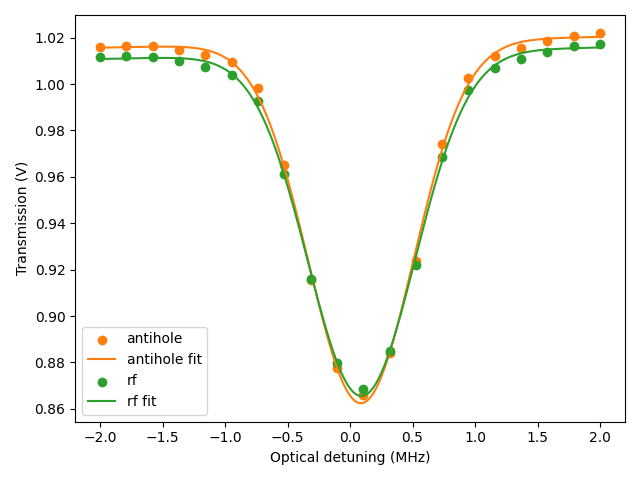

-0.1556758030578602
0.0017333114342916887
0.41977432103958884
0.005973582981811938


In [834]:
plt_monitor = False

antihole_normalized = antihole_avg/chasm_avg
rf_normalized = rf_avg/chasm_avg

fig, ax = plt.subplots()
# ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz, antihole_normalized, label="antihole", color="C1")

antihole_fit = get_gaussian_fit(detunings_MHz, antihole_normalized)
xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    ax.scatter(detunings_MHz, rf_normalized, label="rf", color="C2")
    #ax.scatter(detunings_MHz, np.average(rf_avg, axis=0) / np.average(antihole_avg, axis=0), label="rf / antihole")

    rf_fit = get_gaussian_fit(detunings_MHz, rf_normalized)
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.results["a"])
print(antihole_fit.errors["a"])
print(antihole_fit.results["sigma"])
print(antihole_fit.errors["sigma"])

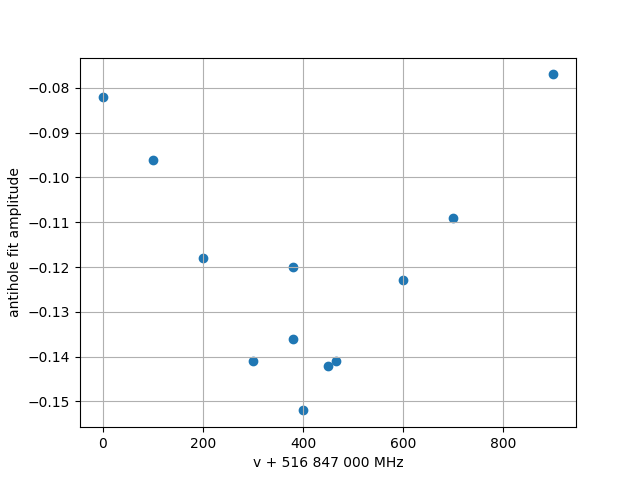

In [706]:
# fig, ax = plt.subplots()
# # ax.scatter(detunings_MHz, rf_avg, label="chasm", color="C0")
# # ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
# ax.scatter(detunings_MHz, rf_avg/chasm_avg)
# plt.show()


# a     sigma freq num
#-0.120 0.331 380 3778
#-0.154 0.349 450 3779 - while scanning
#-0.144 0.356 500 3780 - while scanning
#-0.138 0.376 465 3781 - while scanning
#-0.141 0.354 465 3782
#-0.142 0.385 450 3783
#-0.123 0.334 600 3784
#-0.109 0.332 700 3785
#-0.077 0.367 900 3786
#-0.141 0.396 300 3787
#-0.118 0.388 200 3788


freqs = [380, 465, 450, 600, 700, 900, 300, 200, 100, 0, 400, 380]
aas = [-0.120, -0.141, -0.142, -0.123, -0.109, -0.077, -0.141, -0.118, -0.096, -0.082, -0.152, -0.136]


fig, ax = plt.subplots()
ax.scatter(freqs, aas)
ax.set_ylabel("antihole fit amplitude")
ax.set_xlabel("v + 516 847 000 MHz")
plt.grid()
plt.show()

In [769]:
def excited_state_population(Omega, t, delta):
    W = np.sqrt(Omega**2 + delta**2)
    return Omega**2 / W**2 * np.sin(W * t / 2) ** 2

In [805]:
def excited_state_population_inhom(Omega, t, delta_max, steps):
    total = np.zeros(len(t))
    for delta in np.linspace(-delta_max, delta_max, steps):
        total += excited_state_population(Omega, t, delta)
    return total / steps

TypeError: object of type 'float' has no len()

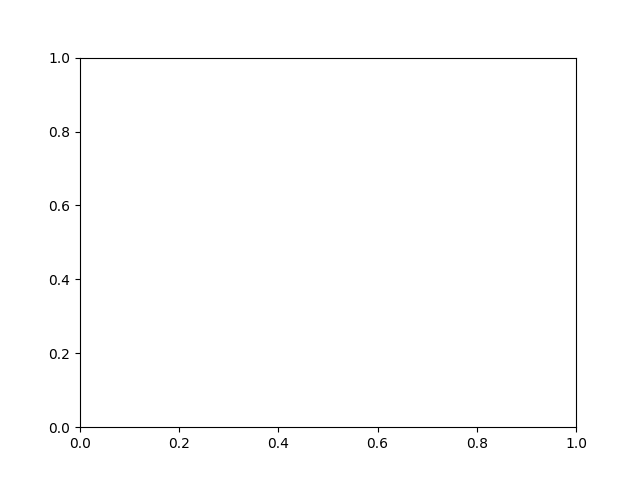

In [812]:
fig, ax = plt.subplots()
t = 0.2e-3
Omegas = np.linspace(0, 0.5e5, 300)
ax.plot(Omegas, excited_state_population_inhom(Omegas, 2*t, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 2, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 4, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 8, 100000, 100000))
ax.plot(Omegas, excited_state_population_inhom(Omegas, t / 16, 100000, 100000))
plt.show()

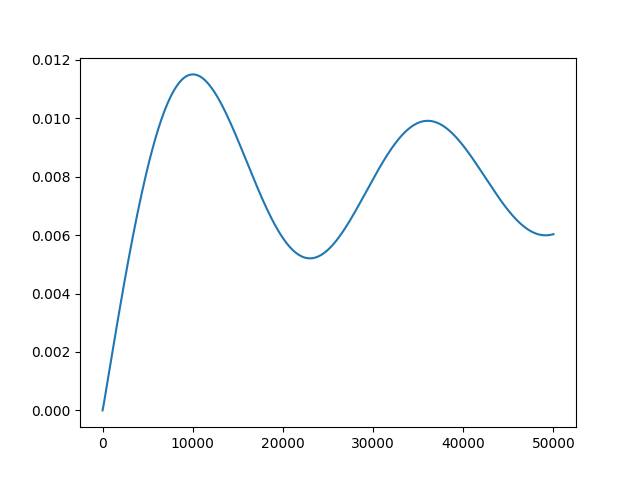

In [810]:
fig, ax = plt.subplots()
Omega = 1e3
ts = np.linspace(0, 12e-3, 300)
ax.plot(Omegas, excited_state_population_inhom(Omega, ts, 100000, 100000))
plt.show()